# replicate Rimsha result

In [1]:
import numpy as np
import pandas as pd
import math
import os
import tqdm

region_folder = "./brain_region_extracted/"
path_mov = "./csv_output/500_days_of_summer_bin.csv"
# now iterate though all region 
region_list_subjet = []
# start 62, end 5376

# extract region with subtitle
df = pd.read_csv(path_mov)
voxel_extraction =[] #size ((19+other region) * X)
count_extraction = [] #size (X, 1)
label_all = []
start_all = []
end_all = []
tmp = 0
segment = 0

In [3]:
df


,Unnamed: 0,start_time,end_time,sentence,3class_vad,bin1_vad,bin2_vad,3class_tb,bin1_tb,bin2_tb,roberta,distBERT
0,0,61.960,65.16,this is a story of boy meets girl,0,1,0,0,1,0,0,1
1,1,69.280,77.56,the boy tom hansen of margate new jersey grew ...,-1,0,0,1,1,1,0,0
2,2,77.680,85.08,this belief stemmed from early exposure to sad...,-1,0,0,-1,0,0,-1,0
3,3,85.200,87.40,elaine elaine,0,1,0,0,1,0,0,1
4,4,87.519,92.60,the girl summer finn of shinnecock michigan di...,-1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1292,1292,5354.960,5358.36,what s this about i figured love would shine t...,1,1,1,1,1,1,0,1
1293,1293,5358.479,5361.84,we ve lost romance this world its turns will s...,1,1,1,0,1,0,-1,1
1294,1294,5361.960,5365.24,open your mind believe it s gonna come true,1,1,1,1,1,1,1,1
1295,1295,5365.359,5368.84,keep romance alive and hope she s gonna tell you,1,1,1,1,1,1,1,1


# mark region with subtitle

In [2]:
for index, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    start,end = math.ceil(row['start_time']),math.ceil(row['end_time']) # apply ceil function
    class_3c = np.array([[row['3class_tb']],[row['roberta']],[row['3class_vad']]])
    class_bin1 = np.array([[row['bin1_tb']],[row['distBERT']],[row['bin1_vad']]])
    class_bin2= np.array([[row['bin2_tb']],[row['bin2_vad']]])

    if tmp == 0:
        tmp = end
    elif start != tmp:
        start = tmp
    tmp = end

    count = np.repeat(segment,end-start)
    label_3c = np.repeat(class_3c, end-start,axis =1)
    label_bin1 = np.repeat(class_bin1, end-start,axis =1)
    label_bin2 = np.repeat(class_bin2, end-start,axis =1)
    count = count[np.newaxis,:]
    #slice_vox = region_list_subjet[:,start:end] #TR = 1, 1 second = 1 voxel
    segment += 1
    if len(count_extraction) == 0:
        #voxel_extraction = slice_vox
        count_extraction = count
        label_all_3c = label_3c
        label_all_b1 = label_bin1
        label_all_b2 = label_bin2
        start_all  = start
        end_all = end
    else:
        #voxel_extraction = np.hstack((voxel_extraction,slice_vox))
        count_extraction = np.hstack((count_extraction,count))
        label_all_3c = np.hstack((label_all_3c,label_3c))
        label_all_b1 = np.hstack((label_all_b1,label_bin1))
        label_all_b2 = np.hstack((label_all_b2,label_bin2))
        start_all = np.hstack((start_all, start))
        end_all = np.hstack((end_all, end))
        

100%|██████████| 1297/1297 [00:00<00:00, 20737.68it/s]


# Extract region fMRI information and assign label of 3 models

In [77]:
# extract fmri voxel from region
for folder in os.listdir(region_folder):

    folder_path = os.path.join(region_folder, folder)
    region_all = pd.DataFrame()
    
    if not os.path.isdir(folder_path) or len(os.listdir(folder_path)) < 5:
        print(f"Skipping {folder}, not a directory or folder contain no region.")
        continue

    if int(folder[4:]) > 20:
        continue

    # Collect all region data in the folder
    region_list_all = []
    for files in os.listdir(folder_path):
        file = os.path.join(folder_path, files)
        region_list= []

        if not os.path.isfile(file):
            continue
        with open(file, "r", encoding='utf-8-sig') as f:
            string = f.read()
            lines = string.split("\n")
            for line in lines: 
                d = line.split()
                list = [float(item) for item in d]
                if len(list) != 0:
                    region_list.append(list)
        if len(region_list_all) == 0:
            region_list_all = np.array(region_list)
        else:
            region_list = np.array(region_list)
            region_list_all = np.vstack((region_list_all, region_list))

    # filter region based on the time with subtitle
    region_segments = []
    for s, e in zip(start_all, end_all):
        region_segments.append(region_list_all[:, int(s):int(e)])
    if region_segments:
        region_list_all = np.hstack(region_segments)
    else:
        region_list_all = np.empty((region_list_all.shape[0], 0))

    # add label to region (114,xx)
    region_list_all = np.vstack((region_list_all,label_all_3c,label_all_b1,label_all_b2))

    # add subject nuber to the first row
    subject= np.repeat(folder, region_list_all.shape[1])
    if len(region_list_subjet)  == 0:
        region_list_subjet = np.vstack((subject[np.newaxis,:], region_list_all))
    else:
        reg_subject = np.vstack((subject[np.newaxis,:], region_list_all))
        region_list_subjet = np.hstack(( region_list_subjet, reg_subject))

    print(f"Processing region: {folder}, shape: {region_list_subjet.shape}")

Processing region: sub_1, shape: (120, 111594)
Processing region: sub_10, shape: (120, 116908)
Processing region: sub_11, shape: (120, 122222)
Processing region: sub_12, shape: (120, 127536)
Processing region: sub_13, shape: (120, 132850)
Processing region: sub_14, shape: (120, 138164)
Processing region: sub_15, shape: (120, 143478)
Processing region: sub_16, shape: (120, 148792)
Processing region: sub_17, shape: (120, 154106)
Processing region: sub_18, shape: (120, 159420)
Processing region: sub_19, shape: (120, 164734)
Processing region: sub_2, shape: (120, 170048)
Processing region: sub_20, shape: (120, 175362)
Skipping sub_21, not a directory or folder contain no region.
Skipping sub_22, not a directory or folder contain no region.
Skipping sub_23, not a directory or folder contain no region.
Skipping sub_24, not a directory or folder contain no region.
Skipping sub_25, not a directory or folder contain no region.
Skipping sub_26, not a directory or folder contain no region.
Skippi

In [76]:
region_list_subjet[0,:]

array(['sub_1', 'sub_1', 'sub_1', ..., 'sub_9', 'sub_9', 'sub_9'],
      dtype='<U32')

# start training

In [4]:
region_list_subjet = region_list_subjet.T
region_list_subjet_pd = pd.DataFrame(region_list_subjet, columns=['subject'] + [f'region_{i}' for i in range(1, region_list_subjet.shape[1]-8)] + ['textblob', 'roberta', 'vader','bin1_tb','distBERT','bin1_vad','bin2_tb','bin2_vad'])

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# 1. Load your dataset
X = region_list_subjet_pd.iloc[:, 1:-9].values  # Features (all regions except labels)
y_textBlob = region_list_subjet_pd['textblob']
y_roberta = region_list_subjet_pd['roberta']  # Unused
y_vader = region_list_subjet_pd['vader']  # Unused

y_textBlob_bin1 = region_list_subjet_pd['bin1_tb']
y_dist_bert = region_list_subjet_pd['distBERT']  # Unused
y_vader_bin1 = region_list_subjet_pd['bin1_vad']  # Unused

y_textBlob_bin2 = region_list_subjet_pd['bin2_tb']
y_vader_bin2 = region_list_subjet_pd['bin2_vad']  # Unused

## SVM

### 3c

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import json
RANDOM_STATE = 42

X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob, test_size=0.2, random_state=RANDOM_STATE, stratify=y_textBlob)
# Then, split train+val into train (60%) and validation (20%) with stratification
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)
# 4. Imbalance correction: SMOTE
# Map labels to integers: -1.0 -> 0, 0.0 -> 1, 1.0 -> 2
class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_train_mapped = pd.Series(y_train).map(class_mapping).values
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append(('svm', SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo', random_state=RANDOM_STATE, probability=False, shrinking=True, tol=1e-3, max_iter=-1)))
pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train_mapped)

# Save the whole pipeline (includes scaler and svm; SMOTE is only used during fit)
joblib.dump(pipeline, 'svm_textBlob_pipeline.joblib')

# Load later
#pipeline_loaded = joblib.load('svm_pipeline.pkl')

# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("Validation Set Accuracy:", accuracy_score(y_val_mapped, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val_mapped, y_val_pred, target_names=['-1.0', '0.0', '1.0']))

y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred, target_names=['-1.0', '0.0', '1.0']))

Validation Set Accuracy: 0.48734474971772673

Validation Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.11      0.12      0.12      2068
         0.0       0.62      0.66      0.64     13020
         1.0       0.30      0.25      0.27      6168

    accuracy                           0.49     21256
   macro avg       0.34      0.34      0.34     21256
weighted avg       0.48      0.49      0.48     21256


Test Set Accuracy: 0.48819156943921715

Test Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.11      0.13      0.12      2068
         0.0       0.62      0.66      0.64     13020
         1.0       0.30      0.25      0.27      6168

    accuracy                           0.49     21256
   macro avg       0.34      0.34      0.34     21256
weighted avg       0.48      0.49      0.48     21256




Test Set Accuracy: 0.48819156943921715

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.13      0.12      2068
           1       0.62      0.66      0.64     13020
           2       0.30      0.25      0.27      6168

    accuracy                           0.49     21256
   macro avg       0.34      0.34      0.34     21256
weighted avg       0.48      0.49      0.48     21256



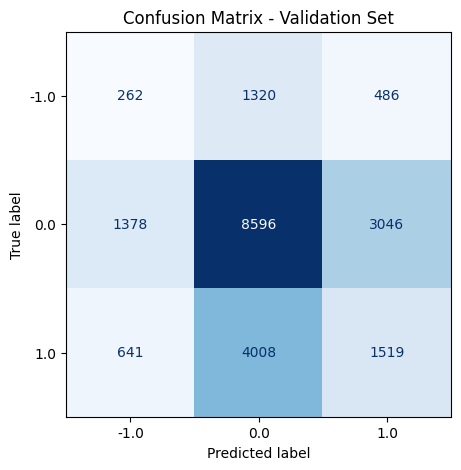

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./svm_textBlob_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob, test_size=0.2, random_state=RANDOM_STATE, stratify=y_textBlob)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)

class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred))

cm = confusion_matrix(y_test_mapped, y_test_pred, labels=[0.0, 1.0, 2.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-1.0', '0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [44]:
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import json
RANDOM_STATE = 42

X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader, test_size=0.2, random_state=RANDOM_STATE, stratify=y_vader)
# Then, split train+val into train (60%) and validation (20%) with stratification
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)
# 4. Imbalance correction: SMOTE
# Map labels to integers: -1.0 -> 0, 0.0 -> 1, 1.0 -> 2
class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_train_mapped = pd.Series(y_train).map(class_mapping).values
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append(('svm', SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo', random_state=RANDOM_STATE, probability=False, shrinking=True, tol=1e-3, max_iter=-1)))
pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train_mapped)

# Save the whole pipeline (includes scaler and svm; SMOTE is only used during fit)
joblib.dump(pipeline, 'svm_vader_pipeline.joblib')

# Load later
#pipeline_loaded = joblib.load('svm_pipeline.pkl')

# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("Validation Set Accuracy:", accuracy_score(y_val_mapped, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val_mapped, y_val_pred, target_names=['-1.0', '0.0', '1.0']))

y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred, target_names=['-1.0', '0.0', '1.0']))

Validation Set Accuracy: 0.38502070003763644

Validation Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.16      0.20      0.18      3396
         0.0       0.48      0.49      0.49     10116
         1.0       0.38      0.33      0.35      7744

    accuracy                           0.39     21256
   macro avg       0.34      0.34      0.34     21256
weighted avg       0.39      0.39      0.39     21256


Test Set Accuracy: 0.38346819721490405

Test Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.16      0.21      0.18      3396
         0.0       0.48      0.48      0.48     10116
         1.0       0.38      0.33      0.35      7744

    accuracy                           0.38     21256
   macro avg       0.34      0.34      0.34     21256
weighted avg       0.39      0.38      0.39     21256




Test Set Accuracy: 0.38346819721490405

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.21      0.18      3396
           1       0.48      0.48      0.48     10116
           2       0.38      0.33      0.35      7744

    accuracy                           0.38     21256
   macro avg       0.34      0.34      0.34     21256
weighted avg       0.39      0.38      0.39     21256



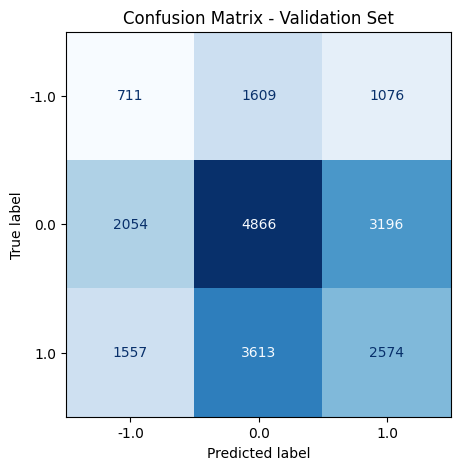

In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./svm_vader_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader, test_size=0.2, random_state=RANDOM_STATE, stratify=y_vader)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)

class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred))

cm = confusion_matrix(y_test_mapped, y_test_pred, labels=[0.0, 1.0, 2.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-1.0', '0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import json
RANDOM_STATE = 42

X_temp, X_test, y_temp, y_test = train_test_split(X, y_roberta, test_size=0.2, random_state=RANDOM_STATE, stratify=y_roberta)
# Then, split train+val into train (60%) and validation (20%) with stratification
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)
# 4. Imbalance correction: SMOTE
# Map labels to integers: -1.0 -> 0, 0.0 -> 1, 1.0 -> 2
class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_train_mapped = pd.Series(y_train).map(class_mapping).values
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append(('svm', SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo', random_state=RANDOM_STATE, probability=False, shrinking=True, tol=1e-3, max_iter=-1)))
pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train_mapped)

# Save the whole pipeline (includes scaler and svm; SMOTE is only used during fit)
joblib.dump(pipeline, 'svm_roberta_pipeline.joblib')

# Load later
#pipeline_loaded = joblib.load('svm_pipeline.pkl')

# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("Validation Set Accuracy:", accuracy_score(y_val_mapped, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val_mapped, y_val_pred, target_names=['-1.0', '0.0', '1.0']))

y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred, target_names=['-1.0', '0.0', '1.0']))

Validation Set Accuracy: 0.4545540082800151

Validation Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.22      0.20      0.21      4672
         0.0       0.59      0.64      0.62     12652
         1.0       0.18      0.16      0.17      3932

    accuracy                           0.45     21256
   macro avg       0.33      0.33      0.33     21256
weighted avg       0.44      0.45      0.44     21256


Test Set Accuracy: 0.4632103876552503

Test Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.23      0.21      0.22      4672
         0.0       0.60      0.65      0.63     12652
         1.0       0.19      0.16      0.17      3932

    accuracy                           0.46     21256
   macro avg       0.34      0.34      0.34     21256
weighted avg       0.44      0.46      0.45     21256




Test Set Accuracy: 0.4632103876552503

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.21      0.22      4672
           1       0.60      0.65      0.63     12652
           2       0.19      0.16      0.17      3932

    accuracy                           0.46     21256
   macro avg       0.34      0.34      0.34     21256
weighted avg       0.44      0.46      0.45     21256



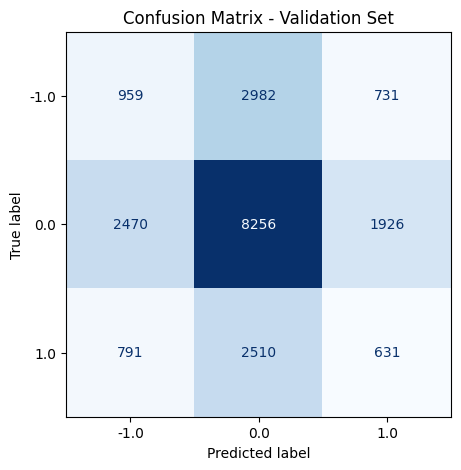

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./svm_roberta_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_roberta, test_size=0.2, random_state=RANDOM_STATE, stratify=y_roberta)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)

class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred))

cm = confusion_matrix(y_test_mapped, y_test_pred, labels=[0.0, 1.0, 2.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-1.0', '0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

### bin1

In [37]:
# 2. Train-validation-test split (60% train, 20% validation, 20% test)
# First, split into train+val (80%) and test (20%) with stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob_bin1, test_size=0.2, random_state=42, stratify=y_textBlob_bin1)
# Then, split train+val into train (60%) and validation (20%) with stratification
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append(('svm', SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo', random_state=RANDOM_STATE, probability=False, shrinking=True, tol=1e-3, max_iter=-1)))
pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, 'svm_bin1_textblob_pipeline.joblib')

# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. Evaluate on test set (final evaluation)
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

Validation Set Accuracy: 0.8011855476100865

Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.11      0.14      0.12      2164
         1.0       0.90      0.88      0.89     19092

    accuracy                           0.80     21256
   macro avg       0.51      0.51      0.51     21256
weighted avg       0.82      0.80      0.81     21256


Test Set Accuracy: 0.8031614602935642

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.12      0.15      0.13      2164
         1.0       0.90      0.88      0.89     19092

    accuracy                           0.80     21256
   macro avg       0.51      0.51      0.51     21256
weighted avg       0.82      0.80      0.81     21256




Test Set Accuracy: 0.8031614602935642

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.12      0.15      0.13      2164
         1.0       0.90      0.88      0.89     19092

    accuracy                           0.80     21256
   macro avg       0.51      0.51      0.51     21256
weighted avg       0.82      0.80      0.81     21256



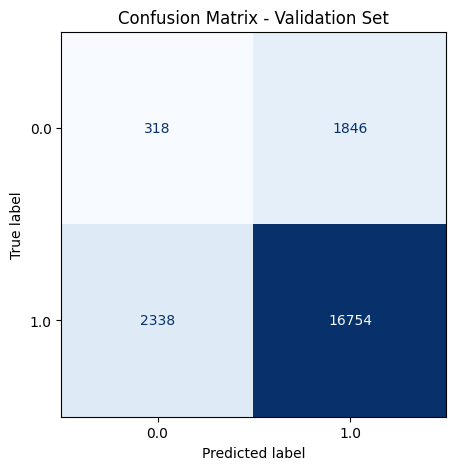

In [39]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./svm_bin1_textblob_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob_bin1, test_size=0.2, random_state=RANDOM_STATE, stratify=y_textBlob_bin1)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)


y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=['0.0', '1.0'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [ ]:
# 2. Train-validation-test split (60% train, 20% validation, 20% test)
# First, split into train+val (80%) and test (20%) with stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y_dist_bert, test_size=0.2, random_state=42, stratify=y_dist_bert)
# Then, split train+val into train (60%) and validation (20%) with stratification
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append(('svm', SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo', random_state=RANDOM_STATE, probability=False, shrinking=True, tol=1e-3, max_iter=-1)))
pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, 'svm_bin1_roberta_pipeline.joblib')

# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. Evaluate on test set (final evaluation)
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

Validation Set Accuracy: 0.5164188934888972

Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.47      0.46      9372
         1.0       0.57      0.56      0.56     11884

    accuracy                           0.52     21256
   macro avg       0.51      0.51      0.51     21256
weighted avg       0.52      0.52      0.52     21256


Test Set Accuracy: 0.5095502446368084

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.47      0.46      9372
         1.0       0.56      0.54      0.55     11884

    accuracy                           0.51     21256
   macro avg       0.50      0.51      0.50     21256
weighted avg       0.51      0.51      0.51     21256




Test Set Accuracy: 0.5095502446368084

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.47      0.46      9372
         1.0       0.56      0.54      0.55     11884

    accuracy                           0.51     21256
   macro avg       0.50      0.51      0.50     21256
weighted avg       0.51      0.51      0.51     21256



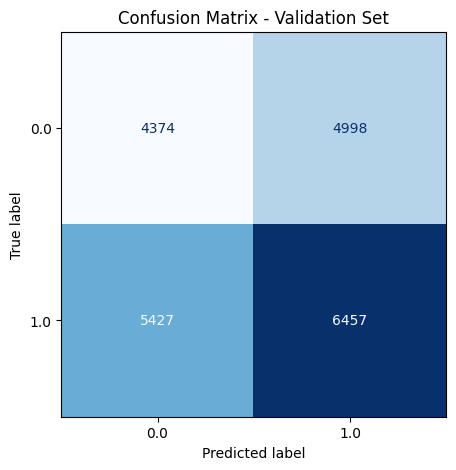

In [40]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./svm_bin1_roberta_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_dist_bert, test_size=0.2, random_state=RANDOM_STATE, stratify=y_dist_bert)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)


y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=['0.0', '1.0'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [42]:
# 2. Train-validation-test split (60% train, 20% validation, 20% test)
# First, split into train+val (80%) and test (20%) with stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader_bin1, test_size=0.2, random_state=42, stratify=y_vader_bin1)
# Then, split train+val into train (60%) and validation (20%) with stratification
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append(('svm', SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo', random_state=RANDOM_STATE, probability=False, shrinking=True, tol=1e-3, max_iter=-1)))
pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, 'svm_bin1_vader_pipeline.joblib')

# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. Evaluate on test set (final evaluation)
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

Validation Set Accuracy: 0.7133985698155815

Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.18      0.20      0.19      3532
         1.0       0.84      0.82      0.83     17724

    accuracy                           0.71     21256
   macro avg       0.51      0.51      0.51     21256
weighted avg       0.73      0.71      0.72     21256


Test Set Accuracy: 0.7133515242754986

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.17      0.18      0.17      3532
         1.0       0.83      0.82      0.83     17724

    accuracy                           0.71     21256
   macro avg       0.50      0.50      0.50     21256
weighted avg       0.72      0.71      0.72     21256




Test Set Accuracy: 0.7133515242754986

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.17      0.18      0.17      3532
         1.0       0.83      0.82      0.83     17724

    accuracy                           0.71     21256
   macro avg       0.50      0.50      0.50     21256
weighted avg       0.72      0.71      0.72     21256



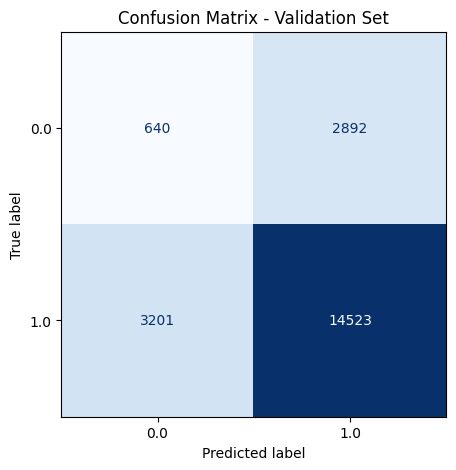

In [45]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./svm_bin1_vader_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader_bin1, test_size=0.2, random_state=RANDOM_STATE, stratify=y_vader_bin1)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)


y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=['0.0', '1.0'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

### bin2

In [ ]:
# 2. Train-validation-test split (60% train, 20% validation, 20% test)
# First, split into train+val (80%) and test (20%) with stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob_bin2, test_size=0.2, random_state=42, stratify=y_textBlob_bin2)
# Then, split train+val into train (60%) and validation (20%) with stratification
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append(('svm', SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo', random_state=RANDOM_STATE, probability=False, shrinking=True, tol=1e-3, max_iter=-1)))
pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, 'svm_bin2_textblob_pipeline.joblib')

# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. Evaluate on test set (final evaluation)
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

Validation Set Accuracy: 0.5959258562288295

Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.71     14940
         1.0       0.32      0.31      0.32      6316

    accuracy                           0.60     21256
   macro avg       0.51      0.51      0.51     21256
weighted avg       0.59      0.60      0.60     21256


Test Set Accuracy: 0.5946085811065112

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.71     14940
         1.0       0.31      0.31      0.31      6316

    accuracy                           0.59     21256
   macro avg       0.51      0.51      0.51     21256
weighted avg       0.59      0.59      0.59     21256




Test Set Accuracy: 0.5946085811065112

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.71     14940
         1.0       0.31      0.31      0.31      6316

    accuracy                           0.59     21256
   macro avg       0.51      0.51      0.51     21256
weighted avg       0.59      0.59      0.59     21256



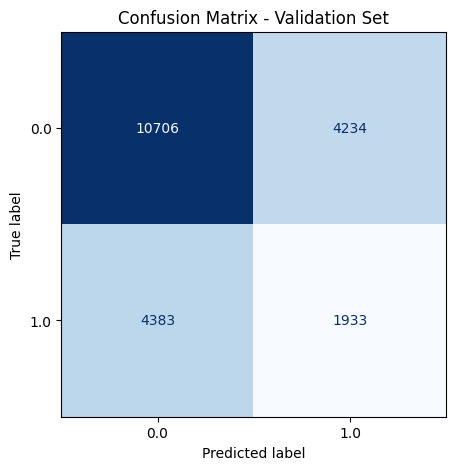

In [46]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./svm_bin2_textblob_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob_bin2, test_size=0.2, random_state=RANDOM_STATE, stratify=y_textBlob_bin2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)


y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=['0.0', '1.0'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [ ]:
# 2. Train-validation-test split (60% train, 20% validation, 20% test)
# First, split into train+val (80%) and test (20%) with stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader_bin2, test_size=0.2, random_state=42, stratify=y_vader_bin2)
# Then, split train+val into train (60%) and validation (20%) with stratification
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append(('svm', SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovo', random_state=RANDOM_STATE, probability=False, shrinking=True, tol=1e-3, max_iter=-1)))
pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, 'svm_bin2_vader_pipeline.joblib')

# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. Evaluate on test set (final evaluation)
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

Validation Set Accuracy: 0.550385773428679

Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.65      0.65     13496
         1.0       0.38      0.37      0.38      7760

    accuracy                           0.55     21256
   macro avg       0.51      0.51      0.51     21256
weighted avg       0.55      0.55      0.55     21256


Test Set Accuracy: 0.5418705306736922

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.65      0.64     13496
         1.0       0.37      0.35      0.36      7760

    accuracy                           0.54     21256
   macro avg       0.50      0.50      0.50     21256
weighted avg       0.54      0.54      0.54     21256




Test Set Accuracy: 0.5418705306736922

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.65      0.64     13496
         1.0       0.37      0.35      0.36      7760

    accuracy                           0.54     21256
   macro avg       0.50      0.50      0.50     21256
weighted avg       0.54      0.54      0.54     21256



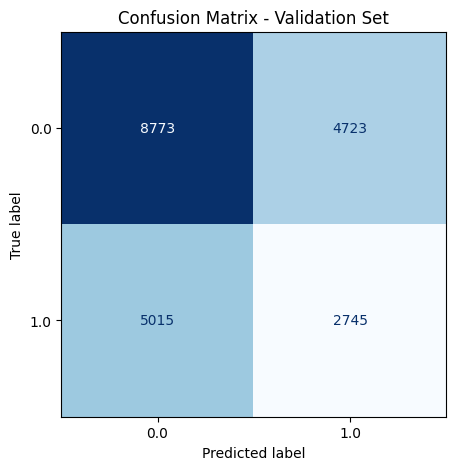

In [53]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./svm_bin2_vader_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader_bin2, test_size=0.2, random_state=RANDOM_STATE, stratify=y_vader_bin2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)


y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=['0.0', '1.0'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

## RFC

### RFC 3c

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import json
RANDOM_STATE = 42

# 2. Train-validation-test split (60% train, 20% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob, test_size=0.2, random_state=42, stratify=y_textBlob)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_train_mapped = pd.Series(y_train).map(class_mapping).values
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append((
    'rf',
    RandomForestClassifier(
        n_estimators=300,        # More trees for stability
        max_depth=None,          # Let trees grow fully (can tune later)
        min_samples_split=2,     # Allow deep splits
        min_samples_leaf=1,      # More granular leaves
        max_features='sqrt',     # Good balance between performance and speed
        bootstrap=True,          # Standard bagging approach
        random_state=42,         # Reproducibility
        n_jobs=-1                # Use all CPU cores
    )
))

pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train_mapped)

# Save the whole pipeline (includes scaler and svm; SMOTE is only used during fit)
joblib.dump(pipeline, 'rf_textBlob_pipeline.joblib')
# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("\nValidation Set Accuracy:", accuracy_score(y_val_mapped, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val_mapped, y_val_pred, target_names=['-1.0', '0.0', '1.0']))

# 8. Evaluate on test set
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred, target_names=['-1.0', '0.0', '1.0']))


Validation Set Accuracy: 0.5716503575461046

Validation Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.11      0.02      0.04      2068
         0.0       0.61      0.88      0.72     13020
         1.0       0.30      0.10      0.15      6168

    accuracy                           0.57     21256
   macro avg       0.34      0.33      0.30     21256
weighted avg       0.47      0.57      0.49     21256


Test Set Accuracy: 0.5720267218667671

Test Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.13      0.03      0.05      2068
         0.0       0.61      0.88      0.72     13020
         1.0       0.29      0.10      0.15      6168

    accuracy                           0.57     21256
   macro avg       0.35      0.34      0.31     21256
weighted avg       0.47      0.57      0.49     21256




Test Set Accuracy: 0.5720267218667671

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.03      0.05      2068
           1       0.61      0.88      0.72     13020
           2       0.29      0.10      0.15      6168

    accuracy                           0.57     21256
   macro avg       0.35      0.34      0.31     21256
weighted avg       0.47      0.57      0.49     21256



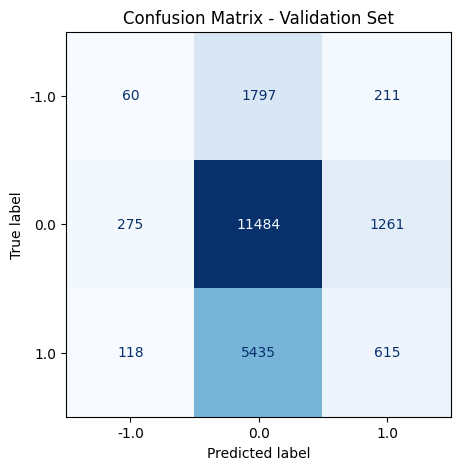

In [49]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./rf_textBlob_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob, test_size=0.2, random_state=RANDOM_STATE, stratify=y_textBlob)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)

class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred))

cm = confusion_matrix(y_test_mapped, y_test_pred, labels=[0.0, 1.0, 2.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-1.0', '0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import json
RANDOM_STATE = 42

# 2. Train-validation-test split (60% train, 20% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader, test_size=0.2, random_state=42, stratify=y_vader)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_train_mapped = pd.Series(y_train).map(class_mapping).values
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append((
    'rf',
    RandomForestClassifier(
        n_estimators=300,        # More trees for stability
        max_depth=None,          # Let trees grow fully (can tune later)
        min_samples_split=2,     # Allow deep splits
        min_samples_leaf=1,      # More granular leaves
        max_features='sqrt',     # Good balance between performance and speed
        bootstrap=True,          # Standard bagging approach
        random_state=42,         # Reproducibility
        n_jobs=-1                # Use all CPU cores
    )
))

pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train_mapped)

# Save the whole pipeline (includes scaler and svm; SMOTE is only used during fit)
joblib.dump(pipeline, 'rf_vader_pipeline.joblib')
# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("\nValidation Set Accuracy:", accuracy_score(y_val_mapped, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val_mapped, y_val_pred, target_names=['-1.0', '0.0', '1.0']))

# 8. Evaluate on test set
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred, target_names=['-1.0', '0.0', '1.0']))


Validation Set Accuracy: 0.42882009785472336

Validation Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.15      0.06      0.08      3396
         0.0       0.48      0.70      0.57     10116
         1.0       0.36      0.24      0.29      7744

    accuracy                           0.43     21256
   macro avg       0.33      0.33      0.31     21256
weighted avg       0.38      0.43      0.39     21256


Test Set Accuracy: 0.4347478359051562

Test Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.15      0.06      0.08      3396
         0.0       0.48      0.69      0.57     10116
         1.0       0.38      0.26      0.31      7744

    accuracy                           0.43     21256
   macro avg       0.34      0.34      0.32     21256
weighted avg       0.39      0.43      0.40     21256




Test Set Accuracy: 0.4347478359051562

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.06      0.08      3396
           1       0.48      0.69      0.57     10116
           2       0.38      0.26      0.31      7744

    accuracy                           0.43     21256
   macro avg       0.34      0.34      0.32     21256
weighted avg       0.39      0.43      0.40     21256



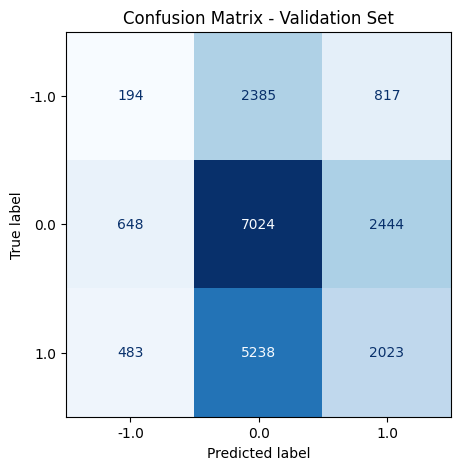

In [51]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./rf_vader_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader, test_size=0.2, random_state=RANDOM_STATE, stratify=y_vader)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)

class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred))

cm = confusion_matrix(y_test_mapped, y_test_pred, labels=[0.0, 1.0, 2.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-1.0', '0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import json
RANDOM_STATE = 42

# 2. Train-validation-test split (60% train, 20% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y_roberta, test_size=0.2, random_state=42, stratify=y_roberta)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_train_mapped = pd.Series(y_train).map(class_mapping).values
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append((
    'rf',
    RandomForestClassifier(
        n_estimators=300,        # More trees for stability
        max_depth=None,          # Let trees grow fully (can tune later)
        min_samples_split=2,     # Allow deep splits
        min_samples_leaf=1,      # More granular leaves
        max_features='sqrt',     # Good balance between performance and speed
        bootstrap=True,          # Standard bagging approach
        random_state=42,         # Reproducibility
        n_jobs=-1                # Use all CPU cores
    )
))

pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train_mapped)

# Save the whole pipeline (includes scaler and svm; SMOTE is only used during fit)
joblib.dump(pipeline, 'rf_roberta_pipeline.joblib')
# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("\nValidation Set Accuracy:", accuracy_score(y_val_mapped, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val_mapped, y_val_pred, target_names=['-1.0', '0.0', '1.0']))

# 8. Evaluate on test set
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred, target_names=['-1.0', '0.0', '1.0']))


Validation Set Accuracy: 0.544269853217915

Validation Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.22      0.08      0.12      4672
         0.0       0.59      0.87      0.71     12652
         1.0       0.15      0.04      0.06      3932

    accuracy                           0.54     21256
   macro avg       0.32      0.33      0.29     21256
weighted avg       0.43      0.54      0.46     21256


Test Set Accuracy: 0.5528321415129845

Test Set Classification Report:
              precision    recall  f1-score   support

        -1.0       0.24      0.08      0.12      4672
         0.0       0.60      0.88      0.71     12652
         1.0       0.20      0.05      0.08      3932

    accuracy                           0.55     21256
   macro avg       0.35      0.34      0.30     21256
weighted avg       0.45      0.55      0.46     21256




Test Set Accuracy: 0.5528321415129845

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.08      0.12      4672
           1       0.60      0.88      0.71     12652
           2       0.20      0.05      0.08      3932

    accuracy                           0.55     21256
   macro avg       0.35      0.34      0.30     21256
weighted avg       0.45      0.55      0.46     21256



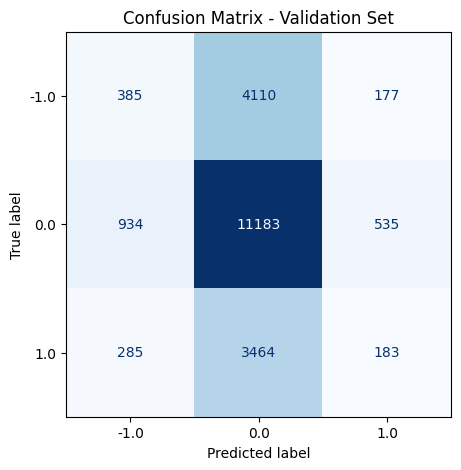

In [52]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./rf_roberta_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_roberta, test_size=0.2, random_state=RANDOM_STATE, stratify=y_roberta)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)

class_mapping = {'-1.0': 0, '0.0': 1, '1.0': 2}
y_val_mapped = pd.Series(y_val).map(class_mapping).values
y_test_mapped = pd.Series(y_test).map(class_mapping).values

y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test_mapped, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test_mapped, y_test_pred))

cm = confusion_matrix(y_test_mapped, y_test_pred, labels=[0.0, 1.0, 2.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['-1.0', '0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

### RFC bin1

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import json
RANDOM_STATE = 42

# 2. Train-validation-test split (60% train, 20% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob_bin1, test_size=0.2, random_state=42, stratify=y_textBlob_bin1)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append((
    'rf',
    RandomForestClassifier(
        n_estimators=300,        # More trees for stability
        max_depth=None,          # Let trees grow fully (can tune later)
        min_samples_split=2,     # Allow deep splits
        min_samples_leaf=1,      # More granular leaves
        max_features='sqrt',     # Good balance between performance and speed
        bootstrap=True,          # Standard bagging approach
        random_state=42,         # Reproducibility
        n_jobs=-1                # Use all CPU cores
    )
))

pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train)

# Save the whole pipeline (includes scaler and svm; SMOTE is only used during fit)
joblib.dump(pipeline, 'rf_tb_bin1_pipeline.joblib')
# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("\nValidation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. Evaluate on test set
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Set Accuracy: 0.874294316898758

Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.12      0.04      0.06      2164
         1.0       0.90      0.97      0.93     19092

    accuracy                           0.87     21256
   macro avg       0.51      0.50      0.49     21256
weighted avg       0.82      0.87      0.84     21256


Test Set Accuracy: 0.874059089198344

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.11      0.03      0.05      2164
         1.0       0.90      0.97      0.93     19092

    accuracy                           0.87     21256
   macro avg       0.50      0.50      0.49     21256
weighted avg       0.82      0.87      0.84     21256




Test Set Accuracy: 0.874059089198344

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.11      0.03      0.05      2164
         1.0       0.90      0.97      0.93     19092

    accuracy                           0.87     21256
   macro avg       0.50      0.50      0.49     21256
weighted avg       0.82      0.87      0.84     21256



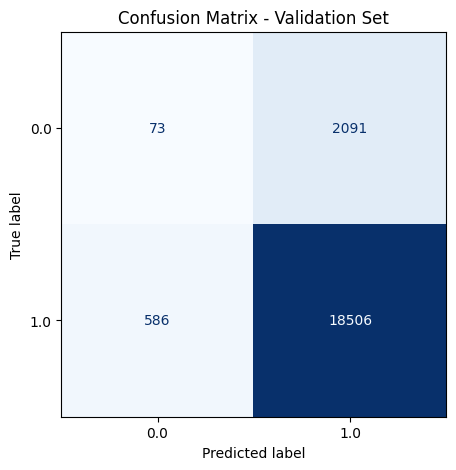

In [54]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./rf_tb_bin1_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob_bin1, test_size=0.2, random_state=RANDOM_STATE, stratify=y_textBlob_bin1)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)


y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=['0.0', '1.0'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import json
RANDOM_STATE = 42

# 2. Train-validation-test split (60% train, 20% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader_bin1, test_size=0.2, random_state=42, stratify=y_vader_bin1)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append((
    'rf',
    RandomForestClassifier(
        n_estimators=300,        # More trees for stability
        max_depth=None,          # Let trees grow fully (can tune later)
        min_samples_split=2,     # Allow deep splits
        min_samples_leaf=1,      # More granular leaves
        max_features='sqrt',     # Good balance between performance and speed
        bootstrap=True,          # Standard bagging approach
        random_state=42,         # Reproducibility
        n_jobs=-1                # Use all CPU cores
    )
))

pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train)

# Save the whole pipeline (includes scaler and svm; SMOTE is only used during fit)
joblib.dump(pipeline, 'rf_vader_bin1_pipeline.joblib')
# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("\nValidation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. Evaluate on test set
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Set Accuracy: 0.7982216785848701

Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.14      0.04      0.07      3532
         1.0       0.83      0.95      0.89     17724

    accuracy                           0.80     21256
   macro avg       0.49      0.50      0.48     21256
weighted avg       0.72      0.80      0.75     21256


Test Set Accuracy: 0.801797139631163

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.16      0.05      0.07      3532
         1.0       0.83      0.95      0.89     17724

    accuracy                           0.80     21256
   macro avg       0.50      0.50      0.48     21256
weighted avg       0.72      0.80      0.75     21256




Test Set Accuracy: 0.801797139631163

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.16      0.05      0.07      3532
         1.0       0.83      0.95      0.89     17724

    accuracy                           0.80     21256
   macro avg       0.50      0.50      0.48     21256
weighted avg       0.72      0.80      0.75     21256



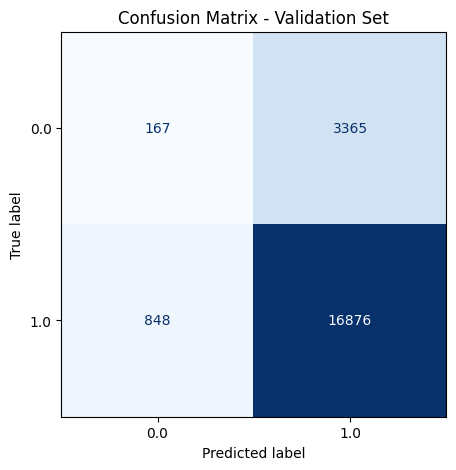

In [55]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./rf_vader_bin1_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader_bin1, test_size=0.2, random_state=RANDOM_STATE, stratify=y_vader_bin1)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)


y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=['0.0', '1.0'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import json
RANDOM_STATE = 42

# 2. Train-validation-test split (60% train, 20% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y_dist_bert, test_size=0.2, random_state=42, stratify=y_dist_bert)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append((
    'rf',
    RandomForestClassifier(
        n_estimators=300,        # More trees for stability
        max_depth=None,          # Let trees grow fully (can tune later)
        min_samples_split=2,     # Allow deep splits
        min_samples_leaf=1,      # More granular leaves
        max_features='sqrt',     # Good balance between performance and speed
        bootstrap=True,          # Standard bagging approach
        random_state=42,         # Reproducibility
        n_jobs=-1                # Use all CPU cores
    )
))

pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train)

# Save the whole pipeline (includes scaler and svm; SMOTE is only used during fit)
joblib.dump(pipeline, 'rf_distBERT_bin1_pipeline.joblib')
# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("\nValidation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. Evaluate on test set
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Set Accuracy: 0.5290741437711705

Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.29      0.35      9372
         1.0       0.56      0.72      0.63     11884

    accuracy                           0.53     21256
   macro avg       0.50      0.50      0.49     21256
weighted avg       0.51      0.53      0.51     21256


Test Set Accuracy: 0.5267218667670305

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.30      0.35      9372
         1.0       0.56      0.71      0.63     11884

    accuracy                           0.53     21256
   macro avg       0.50      0.50      0.49     21256
weighted avg       0.51      0.53      0.51     21256




Test Set Accuracy: 0.5267218667670305

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.30      0.35      9372
         1.0       0.56      0.71      0.63     11884

    accuracy                           0.53     21256
   macro avg       0.50      0.50      0.49     21256
weighted avg       0.51      0.53      0.51     21256



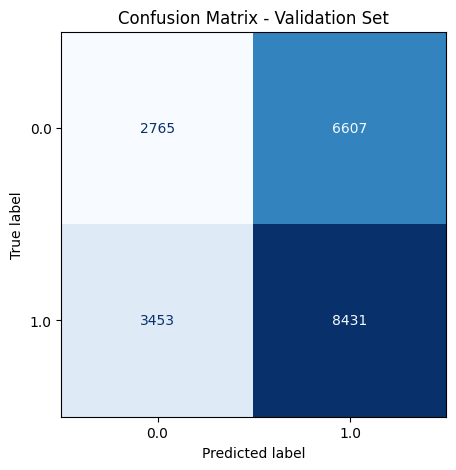

In [58]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./rf_distBERT_bin1_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_dist_bert, test_size=0.2, random_state=RANDOM_STATE, stratify=y_dist_bert)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)


y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=['0.0', '1.0'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

### RFC bin2

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import json
RANDOM_STATE = 42

# 2. Train-validation-test split (60% train, 20% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob_bin2, test_size=0.2, random_state=42, stratify=y_textBlob_bin2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append((
    'rf',
    RandomForestClassifier(
        n_estimators=300,        # More trees for stability
        max_depth=None,          # Let trees grow fully (can tune later)
        min_samples_split=2,     # Allow deep splits
        min_samples_leaf=1,      # More granular leaves
        max_features='sqrt',     # Good balance between performance and speed
        bootstrap=True,          # Standard bagging approach
        random_state=42,         # Reproducibility
        n_jobs=-1                # Use all CPU cores
    )
))

pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train)

# Save the whole pipeline (includes scaler and svm; SMOTE is only used during fit)
joblib.dump(pipeline, 'rf_tb_bin2_pipeline.joblib')
# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("\nValidation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. Evaluate on test set
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Set Accuracy: 0.6645182536695521

Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.91      0.79     14940
         1.0       0.29      0.09      0.14      6316

    accuracy                           0.66     21256
   macro avg       0.50      0.50      0.47     21256
weighted avg       0.58      0.66      0.60     21256


Test Set Accuracy: 0.6678114414753481

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.91      0.79     14940
         1.0       0.30      0.09      0.14      6316

    accuracy                           0.67     21256
   macro avg       0.50      0.50      0.47     21256
weighted avg       0.58      0.67      0.60     21256




Test Set Accuracy: 0.6678114414753481

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.91      0.79     14940
         1.0       0.30      0.09      0.14      6316

    accuracy                           0.67     21256
   macro avg       0.50      0.50      0.47     21256
weighted avg       0.58      0.67      0.60     21256



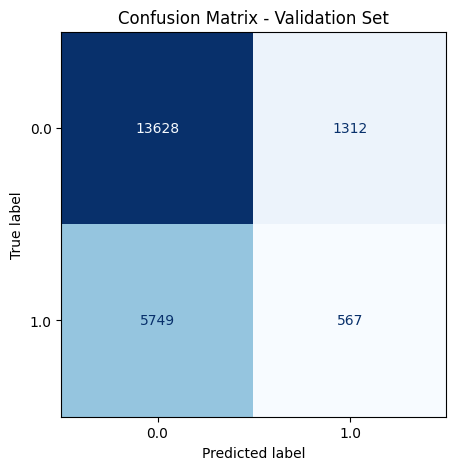

In [59]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./rf_tb_bin2_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_textBlob_bin2, test_size=0.2, random_state=RANDOM_STATE, stratify=y_textBlob_bin2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)


y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=['0.0', '1.0'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import json
RANDOM_STATE = 42

# 2. Train-validation-test split (60% train, 20% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader_bin2, test_size=0.2, random_state=42, stratify=y_vader_bin2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

steps = [('scaler', StandardScaler())]
steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
steps.append((
    'rf',
    RandomForestClassifier(
        n_estimators=300,        # More trees for stability
        max_depth=None,          # Let trees grow fully (can tune later)
        min_samples_split=2,     # Allow deep splits
        min_samples_leaf=1,      # More granular leaves
        max_features='sqrt',     # Good balance between performance and speed
        bootstrap=True,          # Standard bagging approach
        random_state=42,         # Reproducibility
        n_jobs=-1                # Use all CPU cores
    )
))

pipeline = ImbPipeline(steps)

pipeline.fit(X_train, y_train)

# Save the whole pipeline (includes scaler and svm; SMOTE is only used during fit)
joblib.dump(pipeline, 'rf_vader_bin2_pipeline.joblib')
# 7. Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
print("\nValidation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. Evaluate on test set
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Set Accuracy: 0.6002540459164472

Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.86      0.73     13496
         1.0       0.38      0.14      0.21      7760

    accuracy                           0.60     21256
   macro avg       0.51      0.50      0.47     21256
weighted avg       0.54      0.60      0.54     21256


Test Set Accuracy: 0.5986074520135491

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.86      0.73     13496
         1.0       0.37      0.14      0.20      7760

    accuracy                           0.60     21256
   macro avg       0.50      0.50      0.47     21256
weighted avg       0.54      0.60      0.54     21256




Test Set Accuracy: 0.5986074520135491

Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.86      0.73     13496
         1.0       0.37      0.14      0.20      7760

    accuracy                           0.60     21256
   macro avg       0.50      0.50      0.47     21256
weighted avg       0.54      0.60      0.54     21256



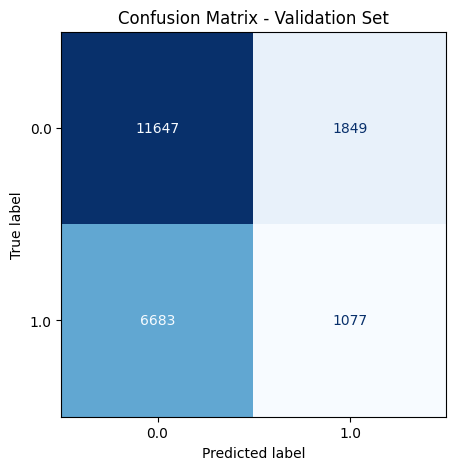

In [60]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
pipeline_loaded = joblib.load("./rf_vader_bin2_pipeline.joblib")
X_temp, X_test, y_temp, y_test = train_test_split(X, y_vader_bin2, test_size=0.2, random_state=RANDOM_STATE, stratify=y_vader_bin2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_temp)


y_test_pred = pipeline_loaded.predict(X_test)
print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=['0.0', '1.0'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0', '1.0'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.show()